In [1]:
%cd -q ..

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from tqdm.notebook import tqdm
import lightgbm as lgb
import shap
import os
import pickle
from src.others.constant import CATEGORICAL
import numpy as np
from sklearn.preprocessing import MinMaxScaler

path_data = r'data\data_modeling'
data_original = pd.read_pickle(os.path.join(path_data, 'data_processed.pkl'))

train = pd.read_pickle(os.path.join(path_data, 'data_model.pkl'))
target = pd.read_pickle(os.path.join(path_data, 'target.pkl'))

In [3]:
params = {
                    'objective': 'regression',
                    'boosting_type':'gbdt',
                    'metric':'rmse',
                    'learning_rate':.05,
                    'max_depth': -1,
                    'num_leaves': 2**10,
                    'colsample_bytree': 0.75,
                    'bagging_fraction':0.75,
                    'bagging_freq': 1,
                    'early_stopping_rounds': 500, 
                    'n_jobs': 1,
                    'verbose': -1
}

strat = data_original['Stanze'].astype(str) + data_original['NIL'].astype(str)
mapping_strat = {x: i for i, x in enumerate(strat.unique())}
strat = strat.map(mapping_strat).astype(int)

In [4]:
score = 0
n_fold = 5
model5 = []

folds = StratifiedKFold(n_splits=n_fold, shuffle = True, random_state = 0)

pred = np.zeros(train.shape[0])

for fold_ , (trn_idx, val_idx) in tqdm(enumerate(folds.split(train, strat))):
        train_x, train_y = train.iloc[trn_idx,:], target.iloc[trn_idx]
        valid_x, valid_y = train.iloc[val_idx,:], target.iloc[val_idx]
        
        model = lgb.train(
            params, lgb.Dataset(train_x, label = train_y, categorical_feature = CATEGORICAL), 
            1000000, valid_sets = lgb.Dataset(valid_x, label = valid_y, categorical_feature = CATEGORICAL),
            valid_names = 'validation', verbose_eval = 500
        )
        
        pred[val_idx] = model.predict(valid_x)
        
        score_fold = model.best_score['validation']['rmse']
        score += score_fold/n_fold 
        model5.append(model)

        print('Fold: {}; RMSE: {:.3f}\n'.format(fold_, score_fold))
        
print('RLMSE : {}'.format(score))



0it [00:00, ?it/s]

The least populated class in y has only 1 members, which is less than n_splits=5.
Found `early_stopping_rounds` in params. Will use it instead of argument
Using categorical_feature in Dataset.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Training until validation scores don't improve for 500 rounds
[500]	validation's rmse: 0.126075
[1000]	validation's rmse: 0.126266
Early stopping, best iteration is:
[556]	validation's rmse: 0.12604
Fold: 0; RMSE: 0.126

Training until validation scores don't improve for 500 rounds
[500]	validation's rmse: 0.124522
[1000]	validation's rmse: 0.124194
Early stopping, best iteration is:
[951]	validation's rmse: 0.12416
Fold: 1; RMSE: 0.124

Training until validation scores don't improve for 500 rounds
[500]	validation's rmse: 0.128356
[1000]	validation's rmse: 0.12775
[1500]	validation's rmse: 0.127731
Early stopping, best iteration is:
[1386]	validation's rmse: 0.127722
Fold: 2; RMSE: 0.128

Training until validation scores don't improve for 500 rounds
[500]	validation's rmse: 0.121978
[1000]	validation's rmse: 0.121575
[1500]	validation's rmse: 0.121581
[2000]	validation's rmse: 0.121574
Early stopping, best iteration is:
[1610]	validation's rmse: 0.121525
Fold: 3; RMSE: 0.122

Training

In [5]:
feature_importances = pd.DataFrame()
feature_importances['feature'] = train.columns


for fold_, mod in tqdm(enumerate(model5)):
    feature_importances['fold_{}'.format(fold_ + 1)] = mod.feature_importance(importance_type='gain')

0it [00:00, ?it/s]

Text(0.5, 1.0, '50 TOP feature importance over 5 average')

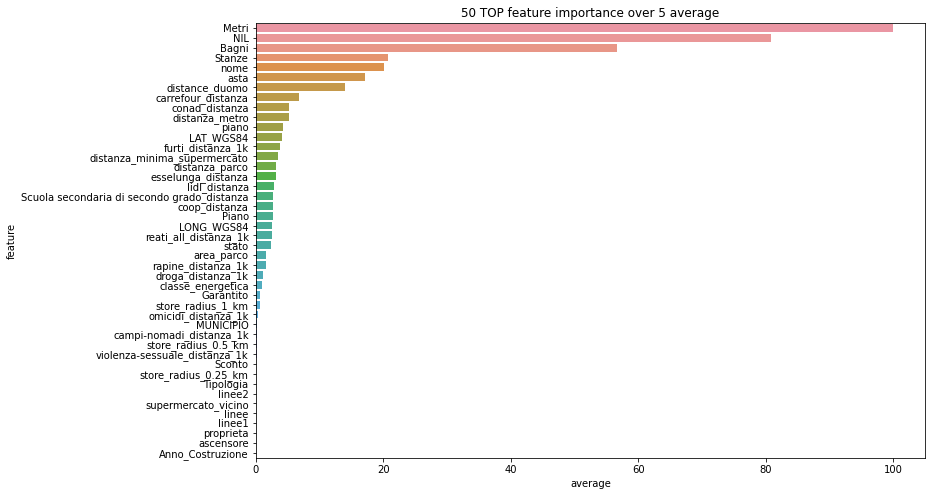

In [6]:
scaler = MinMaxScaler(feature_range=(0, 100))


feature_importances['average'] = scaler.fit_transform(X=pd.DataFrame(feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)))

fig = plt.figure(figsize=(12,8))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} average'.format(fold_+1))

In [7]:
best_ = (np.expm1(pred) - np.expm1(target)).argsort()[::-1].values

In [8]:
result = data_original.copy()
result['Pred'] = np.expm1(pred).astype(int)

result['Diff'] = result['Pred'] - result['Prezzo']
ordered_ = result.iloc[best_, :].reset_index(drop = True)

In [9]:
ordered_

,Prezzo,Prezzo_Vecchio,Sconto,Stanze,Metri,Bagni,Piano,Garantito,Posizione,Url,...,violenza-sessuale_distanza_1k,rapine_distanza_1k,furti_distanza_1k,omicidi_distanza_1k,droga_distanza_1k,campi-nomadi_distanza_1k,reati_all_distanza_1k,distance_duomo,Pred,Diff
0,420000.0,NaN,NaN,5+,189.0,2,Piano Rialzato,NaN,"Appartamento via Salvatore Rosa, Certosa, Milano",https://www.immobiliare.it/annunci/67978325/,...,0,7,8,2,1,0,30,4.438799,916851,496851.0
1,890000.0,NaN,NaN,3,170.0,2,5,NaN,"Trilocale via Farini, Garibaldi - Corso Como, ...",https://www.immobiliare.it/annunci/87590842/,...,0,9,10,0,3,1,37,2.026583,1378894,488894.0
2,1020000.0,NaN,NaN,3,150.0,2,2,NaN,"Trilocale viale Piave 37, Porta Venezia, Milano",https://www.immobiliare.it/annunci/83584313/,...,1,25,12,0,6,2,71,1.922725,1506745,486745.0
3,990000.0,NaN,NaN,3,200.0,3,Terra,garantito,"Trilocale corso Giuseppe Garibaldi 12, Lanza, ...",https://www.immobiliare.it/annunci/84896154/,...,0,7,9,0,5,0,32,1.245854,1415799,425799.0
4,980000.0,NaN,NaN,3,156.0,2,3,garantito,"Trilocale via Giulio Uberti 9, Indipendenza, M...",https://www.immobiliare.it/annunci/85776520/,...,0,11,8,0,5,2,44,2.769339,1393396,413396.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8937,2400000.0,NaN,NaN,3,150.0,2,4,NaN,"Trilocale corso Venezia 3, San Babila, Milano",https://www.immobiliare.it/annunci/62422898/,...,1,11,14,0,7,0,55,0.802637,1760901,-639099.0
8938,1100000.0,NaN,NaN,4,143.0,1,Piano Rialzato,garantito,"Quadrilocale piazza della Conciliazione 4, Vin...",https://www.immobiliare.it/annunci/80121921/,...,0,4,3,0,6,0,23,6.003158,388964,-711036.0
8939,1499000.0,NaN,NaN,5+,152.0,3,Terra,garantito,"Appartamento via Francesco Koristka, Cenisio, ...",https://www.immobiliare.it/annunci/86882014/,...,2,3,7,6,4,0,32,3.915816,757677,-741323.0
8940,2250000.0,NaN,NaN,5,200.0,2,6,NaN,"Appartamento via Alvise Cadamosto, Morgagni, M...",https://www.immobiliare.it/annunci/76934734/,...,1,32,18,2,7,2,92,2.393187,1326484,-923516.0


In [14]:
mask = (ordered_['Diff'] > 0) & (ordered_['Prezzo']>200000) & (ordered_['Prezzo']<350000)
mask = mask & ([x not in ['Terra', 'Piano Rialzato', 'Seminterrato'] for x in ordered_.Piano]) 
mask = mask & (ordered_.Metri > 55) & (ordered_.asta != 'asta')
mask = mask & (ordered_.distance_duomo < 4)

ordered_.loc[mask, ['Prezzo', 'Diff', 'Posizione', 'Url', 'Piano', 'Metri', 'distance_duomo']][:30]

,Prezzo,Diff,Posizione,Url,Piano,Metri,distance_duomo
8,280000.0,345208.0,"Appartamento via Manfredo Fanti, Quadronno - C...",https://www.immobiliare.it/annunci/77556674/,5,100.0,1.196128
106,348000.0,171092.0,"Quadrilocale viale Liguria, Navigli - Darsena,...",https://www.immobiliare.it/annunci/87367298/,6,115.0,2.976762
182,279000.0,132577.0,"Bilocale via Luigi Settembrini 18, Buenos Aire...",https://www.immobiliare.it/annunci/77990494/,1,66.0,2.445388
222,220000.0,121677.0,"Trilocale viale Molise, Martini - Insubria, Mi...",https://www.immobiliare.it/annunci/87487622/,1,80.0,3.618215
224,348000.0,120701.0,"Bilocale via Ugo Bassi 30, Isola, Milano",https://www.immobiliare.it/annunci/87410666/,4,60.0,2.842232
279,338000.0,105683.0,"Bilocale corso 22 Marzo, Indipendenza, Milano",https://www.immobiliare.it/annunci/84487622/,2,65.0,2.326876
291,320000.0,101835.0,"Bilocale via Giovanni De Alessandri, Vercelli ...",https://www.immobiliare.it/annunci/71749262/,2,64.0,3.575219
297,215000.0,101058.0,"Trilocale via Marco d'Agrate 34, Corvetto, Milano",https://www.immobiliare.it/annunci/86221758/,3,85.0,3.522754
300,278000.0,100476.0,"Bilocale via Vitruvio 43, Centrale, Milano",https://www.immobiliare.it/annunci/87592412/,2,70.0,2.575153
309,320000.0,98095.0,"Quadrilocale via Rimini 25, Famagosta, Milano",https://www.immobiliare.it/annunci/86927624/,4,115.0,3.463060
